## 6.4 ディープラーニングの実装

### 確率的勾配降下法 + Dropout

Epoch:0/1000 Error_train:1.1034003735578313 Error_test:1.1036163669002563
Epoch:100/1000 Error_train:0.09429564417484938 Error_test:0.11000898801540752
Epoch:200/1000 Error_train:0.04435988573621166 Error_test:0.07443621679540982
Epoch:300/1000 Error_train:0.03063917409801137 Error_test:0.06995388194555859
Epoch:400/1000 Error_train:0.020659685634025014 Error_test:0.07670717020202102
Epoch:500/1000 Error_train:0.014637750761409898 Error_test:0.08566587624294403
Epoch:600/1000 Error_train:0.010278657872346542 Error_test:0.0915716266411989
Epoch:700/1000 Error_train:0.008689107805426206 Error_test:0.09802802636738293
Epoch:800/1000 Error_train:0.00631751257823059 Error_test:0.11257108612548689
Epoch:900/1000 Error_train:0.005872172325592482 Error_test:0.1139623621402667


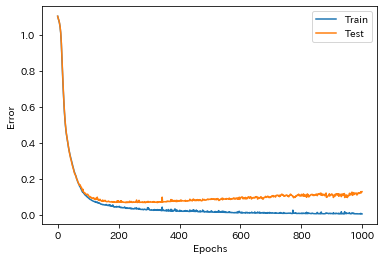

Accuracy Train: 100.0% Accuracy Test: 97.33333333333334%


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- Irisデータの読み込み --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)  # サンプル数

# -- 入力データを標準化する --
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

# -- 正解をone-hot表現にする --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 訓練データとテストデータ --
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]  # 訓練 入力
correct_train = correct_data[index_train, :]  # 訓練 正解
input_test = input_data[index_test, :]  # テスト 入力
correct_test = correct_data[index_test, :]  # テスト 正解

n_train = input_train.shape[0]  # 訓練データのサンプル数
n_test = input_test.shape[0]  # テストデータのサンプル数

# -- 各設定値 --
n_in = 4  # 入力層のニューロン数
n_mid = 50  # 中間層のニューロン数
n_out = 3  # 出力層のニューロン数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 1000
batch_size = 8
interval = 100  # 経過の表示間隔


# -- 各層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # 重み（行列）
        self.b = wb_width * np.random.randn(n)  # バイアス（ベクトル）
        
    def update(self, eta):      
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 中間層 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)  # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLUの微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 出力層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 
        
# -- ドロップアプト --
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio  # ニューロンを無効にする確率

    def forward(self, x, is_train):  # is_train: 学習時はTrue
        if is_train:
            rand = np.random.rand(*x.shape)  # 入力と同じ形状の乱数の行列
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)  # 1:有効 0:無効
            self.y = x * self.dropout  # ニューロンをランダムに無効化
        else:
            self.y = (1-self.dropout_ratio)*x  # テスト時は出力を下げる
        
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout  # 無効なニューロンでは逆伝播しない


# -- 各層の初期化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

# -- 順伝播 --
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)

# -- 逆伝播 --
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)

# -- 重みとバイアスの更新 --
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size  # 交差エントロピー誤差


# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size  # 1エポックあたりのバッチ数
for i in range(epoch):

    # -- 誤差の計測 --  
    forward_propagation(input_train, False)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test, False)
    error_test = get_error(correct_test, n_test)
    
    # -- 誤差の記録 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))

    # -- 学習 -- 
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 順伝播と逆伝播
        forward_propagation(x, True)
        backpropagation(t)
        
        # 重みとバイアスの更新
        uppdate_wb() 

        
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
forward_propagation(input_train, False)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")